### 1D Burger's equation

$u_t + V(x) uu_{x} - (0.01/\pi) u_{xx}, x\in[-1, 1], t\in[0, 1]$

$u(0, x) = -\sin(\pi x),$

$u(t, -1)=u(t, 1)=0$

**The aim is to invert the function $V(x)$, as an example, set $V(x) = |x|$**

In [1]:
import torch
import torch.nn as nn
from torch import autograd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
from copy import deepcopy

### Solve PDE with finite difference using py-pde 

In [2]:
import sys
sys.path.append('./py-pde/')

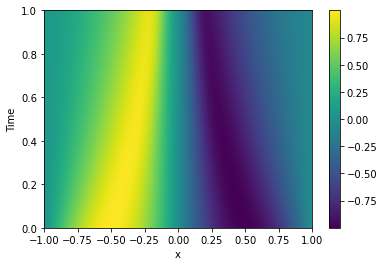

In [3]:
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph, ExplicitSolver

class Burger1D(PDEBase):
    def __init__(self, bc, advection):
        super(Burger1D, self).__init__()
        self.bc = bc
        self.advection = advection
    def evolution_rate(self, u, t=0):
        assert u.grid.dim == 1
        u_x = u.gradient("natural")[0]
        return -self.advection*u*u_x+0.01/np.pi*u.laplace("natural")
    
Nx = 1000
grid = CartesianGrid([[-1, 1]], [Nx], periodic=False)
u = ScalarField.from_expression(grid, "-sin(pi*x)")
advection = ScalarField.from_expression(grid, "abs(x)")

storage = MemoryStorage()
eq = Burger1D(bc={"value": 0.0}, advection=advection)
eq.solve(u, t_range=1, tracker=storage.tracker(0.01), dt=1e-4)

plot_kymograph(storage)

In [4]:
# reshape the output
xb = grid.axes_bounds[0]
x = np.linspace(*xb, grid.shape[0]+2)
t = np.array(storage.times)
x_mesh, t_mesh = np.meshgrid(x[1:-1], t)
fd_sol = torch.from_numpy(np.concatenate(storage.data)).float().reshape(-1, 1)
sol_t = torch.from_numpy(t_mesh.reshape(-1, 1)).float()
sol_x = torch.from_numpy(x_mesh.reshape(-1, 1)).float()

Nobs = 2000
idx = torch.randint(low=0, high=sol_t.shape[0], size=(Nobs,))
obs_t = sol_t[idx, :]
obs_x = sol_x[idx, :]
obs_u = fd_sol[idx, :]
obs_t.requires_grad, obs_x.requires_grad = True, True

### Define a feedforward network

In [5]:
from collections import OrderedDict

class Dense(nn.Module):
    def __init__(self, activation, inputs, outputs):
        super(Dense, self).__init__()
        self.linear = nn.Linear(inputs, outputs)
        self.activation = activation
    
    def forward(self, x):
        return self.activation(self.linear(x))
    
    
class FFN(nn.Module):
    def __init__(self, activation, n_hidden, n_nodes, inputs=2):
        super(FFN, self).__init__()
        self.inputs = inputs
        layers = []
        for i in range(n_hidden+2):
            if i == 0:
                layers.append(Dense(activation, inputs, n_nodes))
            elif i == n_hidden+1:
                layers.append(nn.Linear(n_nodes, 1))
            else:
                layers.append(Dense(activation, n_nodes, n_nodes))
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x, t):
        if self.inputs == 2:
            xt = torch.cat([x, t], axis=1)
            for l in self.layers:
                xt = l(xt)
            return xt
        else:
            for l in self.layers:
                x = l(x)
            return x

### Define pde

In [6]:
# defining the PDE residue
def f(net, x, t, advection):
    u = net(x, t)
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    return u_t + advection(x, t)*u*u_x - 0.01/np.pi*u_xx

In [7]:
# The true initial and boundary value.
def u_init(net, x, t):
    return net(x, t) + torch.sin(np.pi*x)
def u_bc(net, x, t):
    return net(x, t)

### Define loss function, optimizer and train

In [15]:
activation = torch.tanh
n_hidden = 5
n_nodes = 8

In [16]:
net_0 = FFN(activation, n_hidden, n_nodes)
adv_net_0 = FFN(activation, 5, 8, inputs=1)
# initial_state = deepcopy(net_0.state_dict())
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(net_0.parameters()) + list(adv_net_0.parameters()))

In [17]:
# Set number of samples
N_init = 50
N_bc = 50
N_f = 5000
max_epochs = 10000

In [18]:
# Create samples from initial condition
x_init = (2.0*torch.rand((N_init, 1), requires_grad=True) - 1.0).to(device)
t_init = (torch.zeros((N_init, 1), requires_grad=True)).to(device)

# Create samples from boundary condition
t_bc = (torch.rand((N_bc, 1), requires_grad=True)).to(device)
x_bc = (torch.ones((N_bc, 1))).to(device)
x_bc[:int(N_bc/2)] = -1
x_bc.requires_grad = True

# Create data point for pde constraint
x_f = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
t_f = (torch.rand((N_f, 1), requires_grad=True)).to(device)

# Data point for measuring advection term error
x_adv = torch.linspace(-1, 1, 1001, requires_grad=True).reshape(-1, 1).to(device)
adv = torch.abs(x_adv)

pde_errors = []
u_errors = []
adv_errors = []

for epoch in range(max_epochs):
    optimizer.zero_grad()
     
    # loss from boundary and initial condition
    mse_u = mse_loss(u_init(net_0, x_init, t_init), torch.zeros_like(t_init)) + \
    mse_loss(u_bc(net_0, x_bc, t_bc), torch.zeros_like(t_bc))
    
    # loss from PDE
    mse_f = mse_loss(f(net_0, x_f, t_f, adv_net_0), torch.zeros_like(t_f))
    
    # loss from observation
    mse_obs = mse_loss(net_0(obs_x, obs_t), obs_u)
    
    loss = mse_u + mse_f + mse_obs
    
    with autograd.no_grad():
        u = net_0(sol_x, sol_t)
        u_errors.append(mse_loss(u, fd_sol))
        pde_errors.append(loss.item())
        adv_errors.append(mse_loss(adv_net_0(x_adv, 0), adv))
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    # Resample data point for pde constraint
    if (epoch+1) % 20 == 0:
        x_f = (2.0*torch.rand((N_f, 1), requires_grad=True) - 1.0).to(device)
        t_f = (torch.rand((N_f, 1), requires_grad=True)).to(device)
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss is {loss}, error is {u_errors[-1]}, adv error is {adv_errors[-1]}")

Epoch 0: loss is 1.176924228668213, error is 0.4997495412826538, adv error is 0.1026291698217392
Epoch 500: loss is 0.026318378746509552, error is 0.014082785695791245, adv error is 0.18020868301391602
Epoch 1000: loss is 0.0122916828840971, error is 0.0032179374247789383, adv error is 0.04318251833319664
Epoch 1500: loss is 0.007030977867543697, error is 0.002331172116100788, adv error is 0.07149393111467361
Epoch 2000: loss is 0.0039223358035087585, error is 0.0017303058411926031, adv error is 0.06670203804969788
Epoch 2500: loss is 0.0030115856789052486, error is 0.001455172197893262, adv error is 0.06400011479854584
Epoch 3000: loss is 0.0024283211678266525, error is 0.0012291346210986376, adv error is 0.06257279962301254
Epoch 3500: loss is 0.0019800113514065742, error is 0.0010565066477283835, adv error is 0.06130504235625267
Epoch 4000: loss is 0.0016135871410369873, error is 0.0008807038539089262, adv error is 0.053688183426856995
Epoch 4500: loss is 0.0013042828068137169, erro

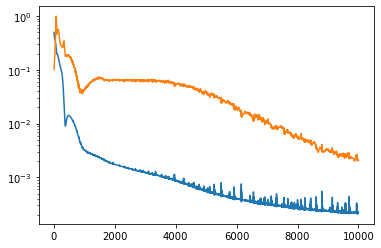

In [19]:
import matplotlib.pyplot as plt
plt.plot(u_errors)
plt.plot(adv_errors)
plt.yscale('log')

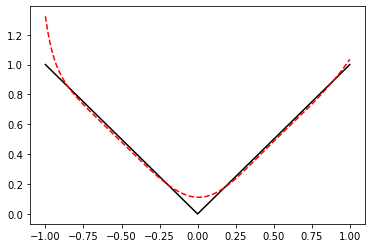

In [20]:
plt.plot(x_adv.detach().numpy(), adv.detach().numpy(), 'k-')
plt.plot(x_adv.detach().numpy(), adv_net_0(x_adv, 0).detach().numpy(), 'r--')